In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report as report
from sklearn.feature_extraction.text import CountVectorizer


### Apply sepsis label to lab and text data

In [2]:
noteevents = pd.read_csv("noteevents_full_icustays.csv") #all text for all patients
patients = pd.read_csv("combined_patients_no_text.csv") #all patient data except for text, including presumed sepsis onset

In [3]:
patients.columns

Index(['Unnamed: 0', 'a:action', 'm:charttime', 'm:icustayid',
       'm:presumed_onset', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:DiaBP', 'o:FiO2_1', 'o:GCS', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb',
       'o:INR', 'o:Magnesium', 'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2',
       'o:Platelets_count', 'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT',
       'o:SIRS', 'o:SOFA', 'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP',
       'o:Temp_C', 'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'r:reward', 'step', 'traj'],
      dtype='object')

In [4]:
sorted(np.unique(patients["m:presumed_onset"]))

[0.0,
 4116096000.0,
 4116282420.0,
 4116681600.0,
 4117651200.0,
 4118256000.0,
 4118817600.0,
 4118860800.0,
 4119292800.0,
 4119874140.0,
 4120451520.0,
 4120934400.0,
 4121193600.0,
 4121366400.0,
 4121412300.0,
 4121613240.0,
 4122219300.0,
 4122394740.0,
 4122489600.0,
 4122582480.0,
 4122706140.0,
 4122748800.0,
 4122796560.0,
 4122798180.0,
 4122802800.0,
 4122976500.0,
 4123353600.0,
 4123364880.0,
 4123414800.0,
 4123910160.0,
 4124030400.0,
 4124102880.0,
 4124104980.0,
 4124173860.0,
 4124625000.0,
 4124822400.0,
 4124908800.0,
 4125029040.0,
 4125305100.0,
 4125427200.0,
 4125499980.0,
 4125686400.0,
 4125772800.0,
 4125816360.0,
 4125826800.0,
 4125829080.0,
 4125859200.0,
 4126118400.0,
 4126550400.0,
 4126803300.0,
 4126807560.0,
 4126930740.0,
 4127047500.0,
 4127234400.0,
 4127328000.0,
 4127673600.0,
 4128105600.0,
 4128364800.0,
 4128796800.0,
 4128969600.0,
 4129184700.0,
 4129315200.0,
 4129360980.0,
 4129656180.0,
 4129660800.0,
 4130265600.0,
 4130784000.0,
 413

In [8]:
patients["sepsis_label"] = np.where(patients["m:presumed_onset"] > 0.0, 1, 0)

In [14]:
patients["sepsis_label"].value_counts()

sepsis_label
0    1102706
1     889233
Name: count, dtype: int64

In [24]:
ids = np.unique(patients["m:icustayid"]).astype("int")
ids

array([200003, 200006, 200007, ..., 299993, 299995, 299999])

In [40]:
x = []
y = []
i = 0
for id in tqdm(ids):
    # get the label for each icustayid and create lookup
    label = np.unique(patients["sepsis_label"].loc[patients["m:icustayid"] == id]).astype("int")
    x.append(id)
    y.append(label.item())
lookup = pd.DataFrame({"icustayid": x,
                       "label": y})

100%|██████████| 43388/43388 [01:17<00:00, 560.17it/s]


In [48]:
lookup["label"].loc[lookup["icustayid"]==200003].item()

1

In [3]:
for id in tqdm(ids):
    label = lookup["label"].loc[lookup["icustayid"]==id].item()
    noteevents.loc[noteevents["icustay_id"] == id, "sepsis_label"] = label

NameError: name 'ids' is not defined

In [50]:
patients.to_csv("patients_no_text_sepsis_labels.csv")

In [1]:
noteevents.to_csv("noteevents_full_icustays_sepsis_labels.csv")

NameError: name 'noteevents' is not defined

### Begin here to load labeled data

In [2]:
lab = pd.read_csv("patients_no_text_sepsis_labels.csv")
noteevents = pd.read_csv("noteevents_full_icustays_sepsis_labels.csv")

In [3]:
lab.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'a:action', 'm:charttime', 'm:icustayid',
       'm:presumed_onset', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:DiaBP', 'o:FiO2_1', 'o:GCS', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb',
       'o:INR', 'o:Magnesium', 'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2',
       'o:Platelets_count', 'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT',
       'o:SIRS', 'o:SOFA', 'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP',
       'o:Temp_C', 'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'r:reward', 'step', 'traj',
       'sepsis_label'],
      dtype='object')

### evaluate feature importance for lab values

In [4]:
print(lab.step.value_counts(bins=5, normalize=True))

step
(-0.079, 15.6]    0.340063
(15.6, 31.2]      0.290511
(31.2, 46.8]      0.187400
(46.8, 62.4]      0.121931
(62.4, 78.0]      0.060095
Name: proportion, dtype: float64


In [3]:
# min step sets how many consecutive steps (in this case hours) patient data needs to contain to be included for feature importance extraction
min_step = 12
# drop some unneccessary columns, get relevant ICUSTAYIDs and rename columns, so that we can proceed
data = lab.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'a:action','r:reward'])
ids = data["m:icustayid"].loc[data["step"] == min_step]
df_ = data.loc[data["m:icustayid"].isin(ids)]


In [650]:
t = noteevents.loc[noteevents["icustay_id"].isin(ids)]
t = t.rename(columns={"icustay_id": "m:icustayid"})
t["m:presumed_onset"] = np.nan

In [651]:
# fill text with presumed onset 
for id in tqdm(ids):
    onset = np.unique(df_["m:presumed_onset"].loc[df_["m:icustayid"] == id])#.astype("int")
    t.loc[t["m:icustayid"] == id, "m:presumed_onset"] = onset[0]

100%|██████████| 41871/41871 [01:13<00:00, 571.94it/s]


In [652]:
# 41871 patients with at least 11 steps
print(len(ids), len(np.unique(df_["m:icustayid"])), len(np.unique(t["m:icustayid"])))

41871 41871 41774


In [9]:
df_.isna().sum()


m:charttime                  0
m:icustayid                  0
m:presumed_onset             0
o:Arterial_BE                0
o:Arterial_lactate           0
o:Arterial_pH                0
o:BUN                        0
o:Calcium                    0
o:Chloride                   0
o:Creatinine                 0
o:DiaBP                      0
o:FiO2_1                     0
o:GCS                        0
o:Glucose                    0
o:HCO3                       0
o:HR                         0
o:Hb                         0
o:INR                        0
o:Magnesium                  0
o:MeanBP                     0
o:PT                         0
o:PTT                        0
o:PaO2_FiO2             885027
o:Platelets_count            0
o:Potassium                  0
o:RR                         0
o:SGOT                       0
o:SGPT                       0
o:SIRS                       0
o:SOFA                       0
o:Shock_Index                0
o:Sodium                     0
o:SpO2  

In [10]:
t.isna().sum()

Unnamed: 0                0
subject_id                0
hadm_id               94169
category                  0
description               0
iserror             1310775
text                      0
charttime            220971
chartdate                 0
storetime            583274
m:icustayid               0
sepsis_label              0
m:presumed_onset          0
dtype: int64

In [11]:
ids.iloc[0]

200003.0

In [686]:
# create granular label: for patients with presumed onset, if chartdate < presumed onset = 0, else 1.
df_["granular_label"] = np.where(((df_["m:charttime"] >= df_["m:presumed_onset"]) & (df_["m:presumed_onset"] > 0.0)), 1, 0)
t["granular_label"] = np.where(((t["chartdate"] >= t["m:presumed_onset"]) & (t["m:presumed_onset"] > 0.0)), 1, 0)
t[["m:presumed_onset", "granular_label", "chartdate","sepsis_label"]].loc[t["m:icustayid"]==ids.iloc[0]]
    

,m:presumed_onset,granular_label,chartdate,sepsis_label
1147423,7.245590e+09,0,7.245072e+09,1.0
1147424,7.245590e+09,0,7.245072e+09,1.0
1147425,7.245590e+09,0,7.245072e+09,1.0
1147426,7.245590e+09,0,7.245072e+09,1.0
1147427,7.245590e+09,0,7.245072e+09,1.0
1147428,7.245590e+09,0,7.245072e+09,1.0
1147429,7.245590e+09,0,7.245072e+09,1.0
1147430,7.245590e+09,0,7.245072e+09,1.0
1147431,7.245590e+09,0,7.245158e+09,1.0
1147432,7.245590e+09,0,7.245158e+09,1.0


In [6]:
#make groundtruth for the selected patients
ground_truth = []
for id in tqdm(ids):
    # get the label for each icustayid and create lookup
    label = np.unique(df_["sepsis_label"].loc[df_["m:icustayid"] == id]).astype("int")
    ground_truth.append(label.item())
#drop empty features, as well as SOFA and SIRS as they are processed from other lab features
df = df_.drop(columns=["granular_label", "m:presumed_onset","o:output_4hourly", "o:output_total", "o:SOFA", "o:SIRS", "step", "traj", "sepsis_label", "o:input_4hourly", "o:input_total", "o:PaO2_FiO2", "o:GCS", "o:PTT", "o:DiaBP", "o:MeanBP", "o:SpO2", "o:cumulated_balance"])
#occurences of septic and non septic in selected patients
Counter(ground_truth).items()

100%|██████████| 41871/41871 [00:34<00:00, 1225.38it/s]


dict_items([(1, 18043), (0, 23828)])

In [34]:
df.columns

Index(['m:charttime', 'm:icustayid', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:FiO2_1', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb', 'o:INR',
       'o:Magnesium', 'o:PT', 'o:Platelets_count', 'o:Potassium', 'o:RR',
       'o:SGOT', 'o:SGPT', 'o:Shock_Index', 'o:Sodium', 'o:SysBP', 'o:Temp_C',
       'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age', 'o:gender',
       'o:max_dose_vaso', 'o:mechvent', 'o:paCO2', 'o:paO2', 'o:re_admission'],
      dtype='object')

In [7]:
# flatten lab data for timeseries classification
cols = list(df.columns)
temp2 = []
for id in tqdm(ids):
    #grab data of one patient
    df_raw = df.loc[df["m:icustayid"] == id] 
    #drop icustayid to avoid learning the id to label correspondence
    d = df_raw.drop(columns=["m:icustayid", "m:charttime"])
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(d.values.flatten()))
df_raw = df.loc[df["m:icustayid"] == id] 
d = df_raw.drop(columns=["m:icustayid", "m:charttime"])
cols = list(d.columns)


100%|██████████| 41871/41871 [00:46<00:00, 904.67it/s]


In [39]:
len(d.columns)

34

In [40]:
len(cols)

34

In [8]:
# trim data to equal length for classification
thresh = min_step*(len(cols)) #-1 since we remove icustayids afterwards, length of data * number of features = one patient for prediction/training
#cutoff = list(filter(lambda i: len(i) >= thresh, temp2))
#ground_truth_cutoff = [ground_truth["sepsis_label"][x] for x, i in enumerate(datalist) if len(i) >= thresh]

preprocessed_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_data)}, {len(preprocessed_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truth)}")
print(f"length of desired patient data: {thresh}")



shape of preprocessed data: [41871, 408]
number of patients: 41871
length of ground truth: 41871
length of desired patient data: 408


In [9]:
df_data = pd.DataFrame(preprocessed_data)
df_data

,0,1,2,3,4,5,6,7,8,9,...,398,399,400,401,402,403,404,405,406,407
0,1.071661,-0.560359,1.069870,-0.380498,0.094949,-0.115152,-0.151959,0.270372,-0.431229,1.257526,...,1.695768,0.298152,-0.165619,-0.963438,-0.5,-2.302585,-0.5,0.342991,2.502016,-0.5
1,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,0.872138,-0.829653,-0.336055,1.456557,...,-0.481630,-0.524785,0.772330,1.187623,0.5,-2.302585,0.5,3.034376,-1.125315,0.5
2,-1.013271,2.161392,-1.359161,0.110697,-0.775842,1.167654,-0.867791,-0.279641,-0.488332,-0.135694,...,-0.886884,0.272831,-0.450723,1.217268,-0.5,-2.302585,0.5,-0.464425,0.110725,-0.5
3,-0.086635,0.016982,0.195419,0.521029,1.090139,0.045199,0.339249,-0.499646,-0.577161,-0.732788,...,-0.481630,0.095583,1.276426,-0.610490,-0.5,-2.302585,-0.5,-1.182127,-0.600200,-0.5
4,1.998297,0.264414,0.584064,0.521029,3.702513,-0.115152,0.339249,-1.324664,-0.355090,-0.732788,...,0.434184,-0.828638,-0.401139,0.164828,-0.5,-2.302585,-0.5,0.881268,0.498502,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41866,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,1.605759,0.109145,-0.684329,-0.644026,...,0.857872,-0.282480,0.254079,-0.456686,-0.5,-2.302585,-0.5,0.892817,-0.381476,-0.5
41867,-0.537904,1.065483,-0.547534,0.471950,0.231097,0.191409,-0.228448,-0.340459,0.055309,-0.175933,...,-0.891924,1.762800,0.164370,0.122087,-0.5,-1.123930,-0.5,-1.229844,-0.385573,-0.5
41868,-1.185859,1.668771,-0.040313,0.242901,0.367001,0.728841,-0.316105,-0.340459,0.872804,-0.644026,...,0.025693,-0.793800,1.608256,-0.160118,-0.5,-2.302585,-0.5,-0.391262,-0.246279,-0.5
41869,-0.969874,-0.518149,0.853363,0.207179,1.726039,-1.600032,-0.316105,-0.115657,0.872804,-0.175933,...,-0.355152,0.182357,-1.616993,-2.147015,-0.5,-2.302585,-0.5,0.132852,-0.008660,-0.5


In [10]:
duplicates = df_data.duplicated()
duplicates.value_counts()

False    41871
Name: count, dtype: int64

#### classify on lab data 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_data, ground_truth, test_size=0.30, random_state=100,stratify=ground_truth)

In [11]:
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_test)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_test).items())


Shape of X_train: 29309
Shape of X_test: 12562
Class Balance in Training Data: dict_items([(0, 16679), (1, 12630)])
Class Balance in Test Data: dict_items([(0, 7149), (1, 5413)])


In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,398,399,400,401,402,403,404,405,406,407
32648,-0.019540,-0.819794,-0.547534,-0.705311,-0.040710,0.191409,-0.145068,-0.958665,-0.528616,1.462392,...,-1.809541,0.120379,2.065344,-1.377562,0.5,-2.302585,-0.5,0.132852,0.253541,-0.5
39478,-1.833814,-0.518149,-2.721339,1.365751,-6.699997,3.774289,2.053002,1.233156,0.172094,-2.282351,...,0.857872,0.275324,-0.104757,-0.721549,-0.5,-2.302585,0.5,-0.181616,-0.098791,-0.5
34078,-0.537904,-0.216505,0.032148,0.409940,-1.127941,1.266273,-0.408503,3.481176,-0.587008,-1.346165,...,2.915955,-0.638854,-0.480680,0.509102,0.5,-2.302585,0.5,0.028029,-0.074210,-0.5
26551,2.053915,-0.367327,0.756749,0.207179,0.502905,-0.883456,0.083131,-0.565261,-0.548080,1.228346,...,-0.596517,-0.112040,-0.318350,0.838335,-0.5,-2.302585,-0.5,0.342498,-0.983718,-0.5
14722,1.303320,-0.560359,0.292580,0.278644,0.841342,-0.756555,0.441462,-1.324664,-0.374125,0.063337,...,0.434184,-0.752675,0.107089,-0.670744,-0.5,-2.302585,-0.5,-0.284999,-0.155872,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37800,-0.019540,0.009728,0.611829,-0.113414,-0.040710,-0.883456,-0.408503,-0.958665,-0.392367,-0.878073,...,0.668429,-0.328963,1.134080,0.526158,-0.5,-2.302585,-0.5,-1.334667,-0.639580,-0.5
3940,4.083228,-0.312927,-0.290388,0.168897,-0.527045,-1.718660,-1.111927,0.820384,0.387261,3.645903,...,-0.886884,0.475400,-0.607736,1.294312,0.5,-2.302585,0.5,1.509258,-0.616357,0.5
18478,0.758006,1.744182,0.575599,0.588882,0.502905,-0.346024,1.039486,-0.115657,0.308343,0.058113,...,-1.272769,-0.297974,-0.549030,1.609353,-0.5,-2.302585,-0.5,-1.334667,-0.754293,-0.5
40486,0.498824,-0.668972,1.481351,1.853613,0.910616,0.012265,1.468970,-0.958665,-0.353438,-0.409980,...,-0.596517,-0.545887,-1.172720,1.355573,-0.5,-2.302585,-0.5,-0.810553,-0.983718,-0.5


In [12]:
clf = make_pipeline(StandardScaler(),HistGradientBoostingClassifier(class_weight="balanced", l2_regularization=0.01, verbose=1))

In [13]:
clf.fit(X_train, y_train)

Binning 0.086 GB of training data: 0.950 s
Binning 0.010 GB of validation data: 0.020 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.62400, val loss: 0.62455, in 0.040s
[2/100] 1 tree, 31 leaves, max depth = 21, train loss: 0.56321, val loss: 0.56463, in 0.044s
[3/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.51413, val loss: 0.51540, in 0.037s
[4/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.46628, val loss: 0.46732, in 0.042s
[5/100] 1 tree, 31 leaves, max depth = 20, train loss: 0.42516, val loss: 0.42551, in 0.037s
[6/100] 1 tree, 31 leaves, max depth = 18, train loss: 0.39397, val loss: 0.39446, in 0.037s
[7/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.36143, val loss: 0.36173, in 0.037s
[8/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.33370, val loss: 0.33415, in 0.060s
[9/100] 1 tree, 31 leaves, max depth = 16, train loss: 0.31118, val loss: 0.31224, in 0.044s
[10/100] 1 tree, 31 leaves, max depth = 16

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.01,
                                                verbose=1))])

In [14]:
print("Score:", clf.score(X_test, y_test))
pr = clf.predict(X_test)
print(report(y_true=y_test, y_pred=pr))

Score: 0.9996019742079286
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7149
           1       1.00      1.00      1.00      5413

    accuracy                           1.00     12562
   macro avg       1.00      1.00      1.00     12562
weighted avg       1.00      1.00      1.00     12562



#### random forest to get feature importances

In [15]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [16]:
print("Score:", forest.score(X_test, y_test))
pr_forest = forest.predict(X_test)
print(report(y_true=y_test, y_pred=pr_forest))

Score: 0.9831237064161757
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7149
           1       0.98      0.98      0.98      5413

    accuracy                           0.98     12562
   macro avg       0.98      0.98      0.98     12562
weighted avg       0.98      0.98      0.98     12562



### Data good enough to learn, maybe too good??
#### Use feature importance to find most relevant features -> Those are the ones we want to learn to predict.

In [17]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = cols*min_step
len(feature_names)


408

In [18]:
forest_importances = pd.DataFrame(importances, index=feature_names)

In [19]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [55]:
df

,0
o:Arterial_BE,0.057686
o:Arterial_lactate,0.006993
o:Arterial_pH,0.016104
o:BUN,0.006444
o:Calcium,0.005686
o:Chloride,0.005813
o:Creatinine,0.017026
o:FiO2_1,0.158755
o:Glucose,0.006924
o:HCO3,0.007553


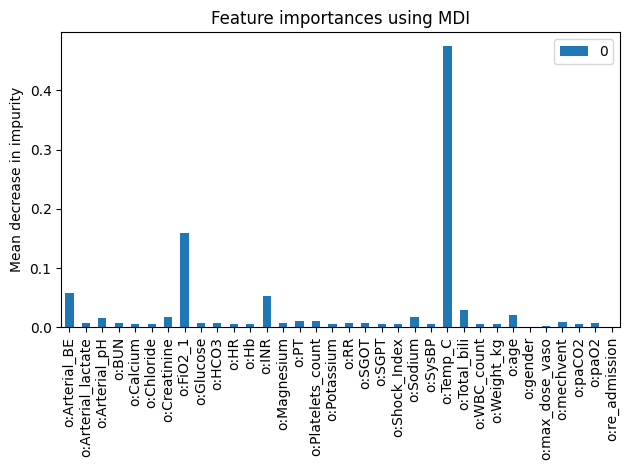

In [21]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)


In [59]:
forest_importances = pd.DataFrame(result.importances_mean, index=feature_names)
forest_importances

,0
o:Arterial_BE,0.0
o:Arterial_lactate,0.0
o:Arterial_pH,0.0
o:BUN,0.0
o:Calcium,0.0
...,...
o:max_dose_vaso,0.0
o:mechvent,0.0
o:paCO2,0.0
o:paO2,0.0


In [31]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [76]:
df.columns

RangeIndex(start=0, stop=1, step=1)

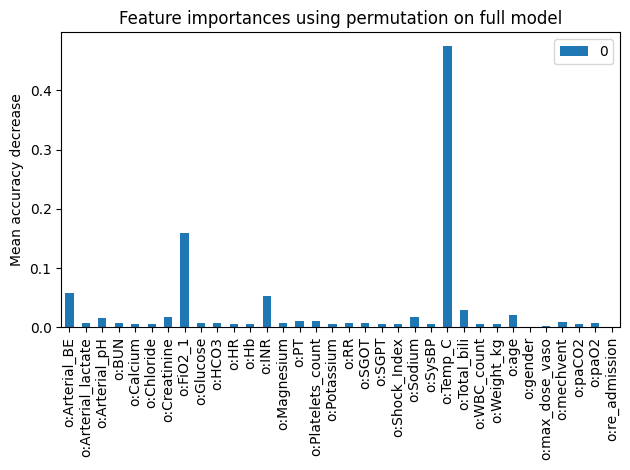

In [32]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### preprocess text
#### apply tfidf to text, and evaluate feature importance

In [518]:
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'ner'])

In [525]:
stops = nlp.Defaults.stop_words
def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


In [678]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_num = re.sub('[0-9]+', '', cleantext)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /Users/pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pablo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [679]:
hh = pd.DataFrame(noteevents[:1000])
s = hh["text"].apply(lambda x: preprocess(x))
#f = hh["text"].apply(lambda x: normalize(x, lowercase=True, remove_stopwords=True))
#print(f)
s


0      neonatology attending triage note baby name kn...
1      nursing transfer note admitted nicu sepsis eva...
2      abdomen contrast pelvis contrast clip clip num...
3      chest portable clip clip number radiology reas...
4      chest portable clip clip number radiology reas...
                             ...                        
995    abdomen contrast pelvis contrast clip clip num...
996    sicu nursing neuro perrl mae normal strength s...
997    ccu npn much pain feel full gas chief abd pain...
998    spine lat clip clip number radiology reason an...
999    sicu npn please see carevue specifics ros neur...
Name: text, Length: 1000, dtype: object

#### this will take a long time

In [680]:
t["clean_text"] = t['text'].map(lambda s:preprocess(s)) 

In [687]:
t.isna().sum()

Unnamed: 0                0
subject_id                0
hadm_id               94169
category                  0
description               0
iserror             1310775
text                      0
charttime            220971
chartdate                 0
storetime            583274
m:icustayid               0
sepsis_label              0
m:presumed_onset          0
clean_text                0
granular_label            0
dtype: int64

In [688]:
t.to_csv("noteevents_preprocessed_text_granular_label.csv")

In [ ]:
t = pd.read_csv("noteevents_preprocessed_text_granular_label.csv")

#### wenn clean text gesaved... text laden, wie unten verfahren, tfid trainieren, mit lab mergen, dann ids von t rausfiltern (sodass es keine NaN tfids gibt). Dann differenz von erstem timestamp zu presumed_onset und von presumed_onset zu letztem timestamp, um die patienten zu bekommen bei denen nach x stunden noch keine sepsis, und NACH Y stunden sepsis! Das sind die patienten anhand deren man tsf testen kann.

In [689]:
data = t.drop(columns=['Unnamed: 0', 'subject_id', 'hadm_id', 'category', 'description',
       'iserror', "charttime", "storetime", "text"])
text_ = data.loc[t["m:icustayid"].isin(ids)]

In [691]:
Counter(text_.granular_label)

Counter({0: 794789, 1: 516751})

#### train a classifier with tfidf head on septic/nonseptic texts

In [692]:
X_train, X_test, y_train, y_test = train_test_split(text_.clean_text, text_.granular_label, test_size=0.30, random_state=100,stratify=text_.granular_label)

In [693]:
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_test)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_test).items())

Shape of X_train: 918078
Shape of X_test: 393462
Class Balance in Training Data: dict_items([(1, 361726), (0, 556352)])
Class Balance in Test Data: dict_items([(1, 155025), (0, 238437)])


In [717]:
clf = Pipeline([
    ("vct", TfidfVectorizer(analyzer="word", stop_words='english',  max_features=100, max_df=0.7, min_df=3, strip_accents='ascii')),
    ("sparse2dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("forest", RandomForestClassifier(random_state=1, n_jobs=-2, verbose=1))
])

In [718]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(report(y_test, y_pred))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    4.6s finished


              precision    recall  f1-score   support

           0       0.71      0.88      0.78    238437
           1       0.70      0.44      0.54    155025

    accuracy                           0.70    393462
   macro avg       0.70      0.66      0.66    393462
weighted avg       0.70      0.70      0.69    393462



#### take a look at learnt parameters and their importance

In [719]:
# len of tfidf vocab and feature_importances
print(len(clf.named_steps["vct"].vocabulary_), len(clf.named_steps["forest"].feature_importances_))

print(list(clf.named_steps["vct"].vocabulary_.keys())[:10])

100 100
['year', 'old', 'medical', 'history', 'hospital', 'pain', 'time', 'blood', 'total', 'respiratory']


In [720]:
importances = clf.named_steps["forest"].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.named_steps["forest"]], axis=0)


In [721]:
forest_importances = pd.DataFrame(importances, index=list(clf.named_steps["vct"].vocabulary_.keys()), columns=["importance_score"])


In [722]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [723]:
# look at the most important vocabs
df.sort_values(by=["importance_score"], ascending=False, inplace=True)
df[:50]

,importance_score
heart,0.020367
impression,0.018699
valve,0.017292
response,0.016792
patient,0.016420
findings,0.016402
blood,0.015968
pain,0.015298
medications,0.015241
placement,0.015169


In [724]:
df[:30].sum()

importance_score    0.426058
dtype: float64

/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_45782/2889208324.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


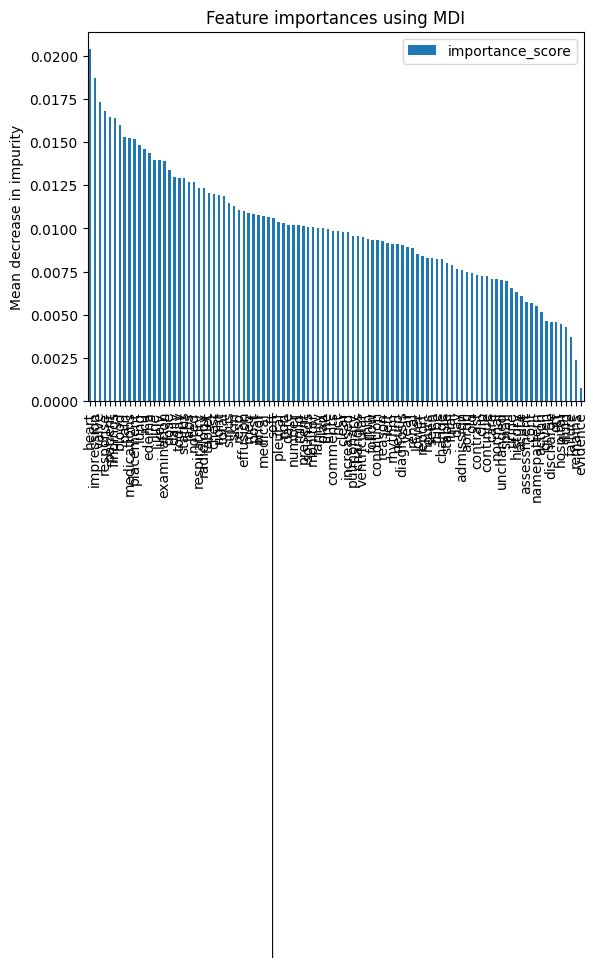

In [725]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### build temporary df containing the tfidf representations of text

In [726]:
text_.columns

Index(['chartdate', 'm:icustayid', 'sepsis_label', 'm:presumed_onset',
       'clean_text', 'granular_label'],
      dtype='object')

In [731]:
df_.columns

Index(['m:charttime', 'm:icustayid', 'm:presumed_onset', 'o:Arterial_BE',
       'o:Arterial_lactate', 'o:Arterial_pH', 'o:BUN', 'o:Calcium',
       'o:Chloride', 'o:Creatinine', 'o:DiaBP', 'o:FiO2_1', 'o:GCS',
       'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb', 'o:INR', 'o:Magnesium',
       'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2', 'o:Platelets_count',
       'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT', 'o:SIRS', 'o:SOFA',
       'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP', 'o:Temp_C',
       'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'step', 'traj', 'sepsis_label',
       'granular_label'],
      dtype='object')

In [730]:
len(df_["m:icustayid"])

1983457

#### combine lab values and tfidf -> THIS IS THE BASE DATA, see how good classifier, then train STrATS on that data.

In [732]:
#combine text and tfidf
temp = text_.copy()
x = pd.DataFrame(clf.named_steps["vct"].transform(temp["clean_text"]).toarray(), index=temp.index).add_prefix('tfidf:')
h = pd.concat([temp, x], axis=1)
ll = h.drop(columns=['sepsis_label', 'm:presumed_onset',
       'granular_label'])
df_ = df_.loc[df_["m:icustayid"].isin(np.unique(ll["m:icustayid"]))]

In [733]:
print(len(np.unique(ll["m:icustayid"])), len(np.unique(df_["m:icustayid"])))

41774 41774


In [734]:
DF1 = df_.sort_values(by="m:charttime")
DF2 = ll.sort_values(by="chartdate")
DF2.rename(columns={"chartdate":"m:charttime"}, inplace=True)
DF1["m:icustayid"] = DF1["m:icustayid"].astype(int)
DF2["m:icustayid"] = DF2["m:icustayid"].astype(int)

#### problem: merge_asof only keeps one match. so text is missing

In [739]:
final_df = pd.merge_asof(DF1, DF2, on="m:charttime", by="m:icustayid", direction='nearest')    
v=final_df.loc[final_df["m:icustayid"]==200066]
v

,m:charttime,m:icustayid,m:presumed_onset,o:Arterial_BE,o:Arterial_lactate,o:Arterial_pH,o:BUN,o:Calcium,o:Chloride,o:Creatinine,...,tfidf:90,tfidf:91,tfidf:92,tfidf:93,tfidf:94,tfidf:95,tfidf:96,tfidf:97,tfidf:98,tfidf:99
1720483,6.903603e+09,200066,6.903619e+09,0.145024,-0.065495,-0.193226,0.874827,0.592544,-0.275503,1.681158,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000
1720485,6.903617e+09,200066,6.903619e+09,0.145024,-0.065495,-0.193226,0.874827,0.592544,-0.275503,1.681158,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000
1720487,6.903621e+09,200066,6.903619e+09,0.145024,-0.065495,-0.193226,0.874827,0.592544,-0.275503,1.681158,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720489,6.903624e+09,200066,6.903619e+09,0.145024,-0.065495,-0.193226,0.874827,0.592544,-0.275503,1.681158,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720491,6.903628e+09,200066,6.903619e+09,0.145024,-0.065495,-0.193226,0.874827,0.592544,-0.275503,1.681158,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720493,6.903631e+09,200066,6.903619e+09,0.376684,0.429368,0.778386,0.874827,0.592544,-0.355678,1.587970,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720495,6.903635e+09,200066,6.903619e+09,0.376684,-0.642836,0.778386,0.874827,0.592544,-0.435854,1.488953,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720497,6.903639e+09,200066,6.903619e+09,0.376684,-0.642836,0.778386,0.874827,0.592544,-0.435854,1.488953,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720500,6.903642e+09,200066,6.903619e+09,0.376684,-0.642836,0.778386,0.874827,0.592544,-0.435854,1.488953,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427
1720502,6.903646e+09,200066,6.903619e+09,0.376684,-0.642836,0.778386,0.874827,0.592544,-0.435854,1.488953,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.122427


In [736]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [752]:
missing_values_table(final_df)

Your selected dataframe has 152 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [751]:
final_df.drop(columns=["o:output_4hourly", "o:output_total", "o:PaO2_FiO2"], inplace=True)

In [742]:
final_df.columns

Index(['m:charttime', 'm:icustayid', 'm:presumed_onset', 'o:Arterial_BE',
       'o:Arterial_lactate', 'o:Arterial_pH', 'o:BUN', 'o:Calcium',
       'o:Chloride', 'o:Creatinine',
       ...
       'tfidf:90', 'tfidf:91', 'tfidf:92', 'tfidf:93', 'tfidf:94', 'tfidf:95',
       'tfidf:96', 'tfidf:97', 'tfidf:98', 'tfidf:99'],
      dtype='object', length=155)

In [753]:
ground_truth = final_df["sepsis_label"]
ffinal = final_df.drop(columns=["m:charttime", 'm:icustayid', 'sepsis_label', "clean_text", "granular_label", "m:presumed_onset"])

In [754]:
ffinal.columns

Index(['o:Arterial_BE', 'o:Arterial_lactate', 'o:Arterial_pH', 'o:BUN',
       'o:Calcium', 'o:Chloride', 'o:Creatinine', 'o:DiaBP', 'o:FiO2_1',
       'o:GCS',
       ...
       'tfidf:90', 'tfidf:91', 'tfidf:92', 'tfidf:93', 'tfidf:94', 'tfidf:95',
       'tfidf:96', 'tfidf:97', 'tfidf:98', 'tfidf:99'],
      dtype='object', length=146)

#### train a classifier with lab + tfidf features

In [755]:
X_train, X_test, y_train, y_test = train_test_split(ffinal, ground_truth, test_size=0.30, random_state=100,stratify=ground_truth)

In [756]:
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_test)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_test).items())

Shape of X_train: 1384710
Shape of X_test: 593448
Class Balance in Training Data: dict_items([(0, 768094), (1, 616616)])
Class Balance in Test Data: dict_items([(1, 264265), (0, 329183)])


In [747]:
clf = make_pipeline(StandardScaler(),HistGradientBoostingClassifier(class_weight="balanced", l2_regularization=0.01, verbose=1))

In [748]:
clf.fit(X_train, y_train)

Binning 1.486 GB of training data: 4.895 s
Binning 0.165 GB of validation data: 0.341 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.59814, val loss: 0.59814, in 0.182s
[2/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.52033, val loss: 0.52033, in 0.166s
[3/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.45544, val loss: 0.45544, in 0.174s
[4/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.40060, val loss: 0.40060, in 0.174s
[5/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.35375, val loss: 0.35375, in 0.166s
[6/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.31339, val loss: 0.31339, in 0.162s
[7/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.27838, val loss: 0.27838, in 0.168s
[8/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.24785, val loss: 0.24785, in 0.163s
[9/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.22110, val loss: 0.22110, in 0.168s
[10/100] 1 tree, 2 leaves, max depth = 1, train loss: 0.1975

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.01,
                                                verbose=1))])

In [757]:
forest = RandomForestClassifier(random_state=0, n_jobs=-2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-2, random_state=0)

In [642]:
print("Score:", forest.score(X_test, y_test))
pr_forest = forest.predict(X_test)
print(report(y_true=y_test, y_pred=pr_forest))

Score: 0.9997692795754745
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    326611
         1.0       1.00      1.00      1.00    262847

    accuracy                           1.00    589458
   macro avg       1.00      1.00      1.00    589458
weighted avg       1.00      1.00      1.00    589458



### Data good enough to learn, maybe too good??
#### Use feature importance to find most relevant features -> Those are the ones we want to learn to predict.

In [758]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = cols*min_step
len(feature_names)


408

In [759]:
forest_importances = pd.DataFrame(importances, index=ffinal.columns)

In [760]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')


#### The most important features are the ones used in the sepsis-3 definition. This is because they were used for labelling of patients -> circular
#### Remove them

In [773]:
df.sort_values(by=0, ascending=False, inplace=True)
df[:20]

,0
o:GCS,0.180742
o:MeanBP,0.134942
o:DiaBP,0.122757
o:SpO2,0.087635
o:PTT,0.084430
o:Temp_C,0.070812
o:input_4hourly,0.066845
o:FiO2_1,0.034038
o:SIRS,0.033351
traj,0.024564


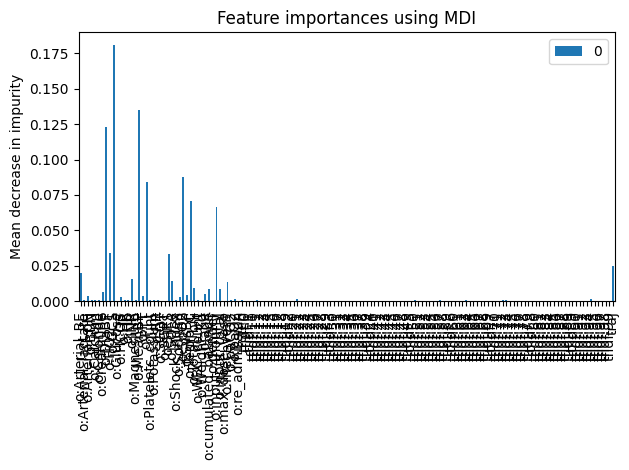

In [762]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [454]:
left_merge = pd.merge_asof(DF1, DF2, on="m:charttime", by="m:icustayid", direction='backward')   

right_merge = pd.merge_asof(DF1, DF2, on="m:charttime", by="m:icustayid", direction='forward') 

merged = (left_merge.merge(right_merge, how="outer")
    .sort_values(['m:icustayid', 'm:charttime'])
    .reset_index(drop=True))



,Unnamed: 0.1,Unnamed: 0,a:action,m:charttime,m:icustayid,m:presumed_onset_x,o:Arterial_BE,o:Arterial_lactate,o:Arterial_pH,o:BUN,...,tfidf:40,tfidf:41,tfidf:42,tfidf:43,tfidf:44,tfidf:45,tfidf:46,tfidf:47,tfidf:48,tfidf:49
0,0,0,10,7.245486e+09,200003,7.245590e+09,1.071661,-0.560359,1.069870,-0.380498,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.324988,0.000000
1,0,0,10,7.245486e+09,200003,7.245590e+09,1.071661,-0.560359,1.069870,-0.380498,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1,1,10,7.245490e+09,200003,7.245590e+09,1.071661,-0.560359,1.069870,-0.380498,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.324988,0.000000
3,1,1,10,7.245490e+09,200003,7.245590e+09,1.071661,-0.560359,1.069870,-0.380498,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2,2,10,7.245493e+09,200003,7.245590e+09,1.071661,-0.560359,1.069870,-0.380498,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.324988,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3966761,1991936,1991936,0,4.659946e+09,299999,0.000000e+00,-0.019540,-0.744383,-0.112773,-0.519833,...,0.096223,0.211528,0.0,0.0,0.0,0.0,0.0,0.0,0.588119,0.201964
3966762,1991937,1991937,0,4.659950e+09,299999,0.000000e+00,-0.019540,-0.744383,-0.112773,-0.519833,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3966763,1991937,1991937,0,4.659950e+09,299999,0.000000e+00,-0.019540,-0.744383,-0.112773,-0.519833,...,0.096223,0.211528,0.0,0.0,0.0,0.0,0.0,0.0,0.588119,0.201964
3966764,1991938,1991938,0,4.660000e+09,299999,0.000000e+00,-0.797086,0.009728,-0.692454,0.055291,...,0.096223,0.211528,0.0,0.0,0.0,0.0,0.0,0.0,0.588119,0.201964


In [460]:
v=merged.loc[merged["m:icustayid"]==200066]
v["text"]

3061    PATIENT/TEST INFORMATION:\nIndication: Congest...
3062    Sinus rhythm. Inferior ST-T wave changes. Mild...
3063    PATIENT/TEST INFORMATION:\nIndication: Congest...
3064    Sinus rhythm. Inferior ST-T wave changes. Mild...
3065    [**2188-10-7**] 1:35 PM\n CHEST (PORTABLE AP) ...
                              ...                        
3144    Atrial fibrillation with rapid ventricular res...
3145    7p-7a\ns:"I'm still in the hospital"\no/a: neu...
3146    Atrial fibrillation with rapid ventricular res...
3147    7p-7a\ns:"I'm still in the hospital"\no/a: neu...
3148    Atrial fibrillation with rapid ventricular res...
Name: text, Length: 88, dtype: object

In [459]:
merged.duplicated()

False    3966766
Name: count, dtype: int64

In [463]:
idtime = lab[["m:icustayid","m:charttime"]]
idtime

,m:icustayid,m:charttime
0,200003.0,7.245486e+09
1,200003.0,7.245490e+09
2,200003.0,7.245493e+09
3,200003.0,7.245497e+09
4,200003.0,7.245500e+09
...,...,...
1991934,299999.0,4.659939e+09
1991935,299999.0,4.659942e+09
1991936,299999.0,4.659946e+09
1991937,299999.0,4.659950e+09


In [482]:
for id in range(0,1):#tqdm(np.unique(idtime["m:icustayid"])):
    times = idtime["m:charttime"].loc[idtime["m:icustayid"]==200066.0]
    text = h.loc[h["m:icustayid"]==200066.0]
    print(text)
    for i, t in enumerate(times-1):
        print(i, t)
        t1 = times.iloc[i]
        t2 = times.iloc[i+1]
        
        t_ = text.loc[text["chartdate"] >= t1]
        t_ = t_.loc[t_["chartdate"]<=t2]
        print(t_)


                                                    text     chartdate  \
9996   [**2188-10-6**] 8:22 PM\n CHEST (PORTABLE AP) ...  6.903533e+09   
9997   0100-7a narrative admission note cont from adm...  6.903619e+09   
9998   [**2188-10-7**] 7:47 AM\n RENAL U.S. PORT     ...  6.903619e+09   
9999   [**2188-10-7**] 1:35 PM\n CHEST (PORTABLE AP) ...  6.903619e+09   
10000  [**2188-10-7**] 10:34 PM\n CHEST (PORTABLE AP)...  6.903619e+09   
10001  CCU ADMIT NPN\nS: " I have to go to work "\nO:...  6.903706e+09   
10002  CCU ADMIT NPN\n0500:ADDENDUM:  pt. continues t...  6.903706e+09   
10003  [**2188-10-8**] 4:08 PM\n T-SPINE; L-SPINE (AP...  6.903706e+09   
10004  CCU NSG NOTE: ALT IN COMFORT/PNEUMONIA/TRAUMA\...  6.903706e+09   
10005  Resp. Care note:\nPatient remains on aerosol F...  6.903706e+09   
10006  7p-7a\ns:"I'm still in the hospital"\no/a: neu...  6.903792e+09   
10007  [**2188-10-10**] 5:16 AM\n CHEST (PORTABLE AP)...  6.903878e+09   
10008  [**2188-10-10**] 10:07 PM\n CT 

IndexError: single positional indexer is out-of-bounds